<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

## Step 1 – Data Loading and Processing (Group)

In [1]:
# Import the Required Packages
'''pip install spacy
pip install googletrans
pip install -U textblob
pip install emot'''

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import spacy
from spacy_langdetect import LanguageDetector
from googletrans import Translator
from langdetect import detect
from textblob import TextBlob
import string
import numpy as np
import re
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, GRU, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import emot
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import nltk
#nltk.download()
from nltk.corpus import stopwords
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

nltk.download('stopwords')
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vince\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.1 Data Loading

In [2]:
## Open and read file

base_dir= os.getcwd()
filename = "facebook.csv"
path_to_file = os.path.join(base_dir, filename)
df = pd.read_csv(filename)
print(df.shape)
print(df.info())

(40000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              39999 non-null  object 
 1   userName              40000 non-null  object 
 2   userImage             40000 non-null  object 
 3   content               39999 non-null  object 
 4   score                 40000 non-null  int64  
 5   thumbsUpCount         40000 non-null  int64  
 6   reviewCreatedVersion  31320 non-null  object 
 7   at                    40000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
dtypes: float64(2), int64(2), object(6)
memory usage: 3.1+ MB
None


In [3]:
# Ensuring each value has 8000 reviews
# Balanced dataset ensures machine learns fairly and will not be biased to any values

df['score'].value_counts()

1    8000
2    8000
3    8000
4    8000
5    8000
Name: score, dtype: int64

In [4]:
## Converting emojis & removing emoticons

# Step 1: Replace emoji with relevant word it represents
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace("_","").replace(":"," ").replace(",","").split("_")))
    return text

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

In [5]:
# Converting df reviews to list and applying the functions

# Removing emoticons because they are uncommon and could confuse the machine (low sample size)
# Converting emojis because they are common and will help with the context and prediction of the review

reviews_list = df['content'].tolist()
reviews_list_c = []
i = len(reviews_list)
for review in reviews_list:
    processing = convert_emojis(str(review))
    final = remove_emoticons(processing)
    reviews_list_c.append(final)
    if i % 100 == 0:
        print(i)
    
    i-=1

40000
39900
39800
39700
39600
39500
39400
39300
39200
39100
39000
38900
38800
38700
38600
38500
38400
38300
38200
38100
38000
37900
37800
37700
37600
37500
37400
37300
37200
37100
37000
36900
36800
36700
36600
36500
36400
36300
36200
36100
36000
35900
35800
35700
35600
35500
35400
35300
35200
35100
35000
34900
34800
34700
34600
34500
34400
34300
34200
34100
34000
33900
33800
33700
33600
33500
33400
33300
33200
33100
33000
32900
32800
32700
32600
32500
32400
32300
32200
32100
32000
31900
31800
31700
31600
31500
31400
31300
31200
31100
31000
30900
30800
30700
30600
30500
30400
30300
30200
30100
30000
29900
29800
29700
29600
29500
29400
29300
29200
29100
29000
28900
28800
28700
28600
28500
28400
28300
28200
28100
28000
27900
27800
27700
27600
27500
27400
27300
27200
27100
27000
26900
26800
26700
26600
26500
26400
26300
26200
26100
26000
25900
25800
25700
25600
25500
25400
25300
25200
25100
25000
24900
24800
24700
24600
24500
24400
24300
24200
24100
24000
23900
23800
23700
23600
23500
2340

In [6]:
# Testing if the functions are working as intended

test_emoji  = "wow😀hi"
test_emoji = convert_emojis(test_emoji)

test_emoticon = "This is a :^)hi"
test_emoticon = remove_emoticons(test_emoticon)

print(test_emoji)
print(test_emoticon)

wow grinningface hi
This is a hi


In [7]:
# Ensuring reviews_list_c is in the correct shape and ensuring that all emojis are converted

print(len(reviews_list_c))
for review in reviews_list_c:
    print(review)

40000
It is amazing
Nice
Facebook doch chkea crash lhot
Bjw [ a ,£ £ @ ව් ව්ද් ඹ්๬ ව්ව් $''a w w
How is app Authentication code generate..?
Poor people this best Apss
My Facebook ID problem please help me
This is very very bad apps, I want to give 0 star. but ni way.
Ok
Banning accounts without any reason let's shift to Twitter and leave this bulshitt app
facebook Your account has been disabled You can't use Facebook or Messenger because your account, or activity on it, didn't follow our Community Standards. We have already reviewed this decision and it can't be reversed. To learn more about the reasons why we disable accounts, visit the Community Standards. Go to Community Standards Not Hunter? Log in here English (UK हिन्दी नेपाली Español Please help me  loudlycryingface  Facebook Time facebook...
Beautiful  redheart ️ smilingfacewithheart-eyes  redheart ️
Utterly depressing
Miss kona sya
Manish
গ্ধ
I don't want the new update. I can't see all stories
Pending restraint order for Murd

Dilkhush kumar raj
Rani,das
F A C I S T S
- ubaidullah 123r
Many ads in my videos. Put the ads in the last part not in the exact middle of the video
, ,
My account has been banned for only reacting to post and stories. Dafak Facebook. Garbage
बहुत ज्यादा समस्या है कई ad जैसे Teen patti , winZo मेरे facebook पर से हट ही नही रहे मै कई बार रिपोर्ट किया बहुत घटिया काम है ये मेरे स्वतंत्रता का हनन है There is a lot of problem, many ads like teen patti, winZo are not going away from my facebook, I have reported many times it is very bad work this is a violation of my freedom
Raju. Sk
It's pretty annoying when i tried to open my saved things, i can't access it. It's really annoying. Now, Facebook have ads? And two ads in one video? Take note that each of it is very long. Also, when i put pics in myday, the quality goes bad, pls fix it.
Nice
Sudipkulung rai
update
ok
Nyc function
Gfkdfu you so sorry Hm maybe you should go with me oo Yoo Hoo jamilidhu tme to Ohk you so I can to get o
Nice smili

Got locked out of my acount cos i didnt turn on facebook protect, i cant log to my acount untill i accept and use this protect. I dont want it i dont need it, and im happy that i can still uninstall at my own free will middlefinger . Wish i could give a -1 stars.
Does not allow you to use your Facebook account after a long unused time
Bar bar apdete problem
Everything is great but I want to get rid of reels on my fb I cannot find reels on settings and privacy to turn it off.
I don't like it
I can't create new account why!!!!!!!!!
Fake news formats
Very poor services
Lots of irrevalent videos.
Well just to add another insult to the already failing Facebook app , marketplace since the delivery thing was added it is just one scam after another non stop adds can not longer sell a used item because no bugger can see it  personfacepalming ‍ malesign ️ fb be getting deleted soon me thinks.
Per day 60 to 70 mb app update and Facebook page is also taking too much data in daily use. It's too muc

This app is disgusting My I d from Facebook is disabled why I don't know and my pubg I d is also lost loudlycryingface  loudlycryingface  loudlycryingface  loudlycryingface 
mark 2l m5r2
I don't know why my acczis suspended . I'm not able to recover it .please tell me what i have to do it now
Good
Very bad app
Proud to be a muslim
a very bad app
Tabidh
Needs to have a minus stars. One is giving it to much
Please unlock my Facebook account My ID log in code please help me
Frequently logged out.. This last update seems Irritating.. Worst experience. facewithrollingeyes 
Reach down problem, i informed to support but it wouldn’t solve yet
I lost my frist gmail account
The DATA is will be more basorss
Hijk Jgd him Jsjjebt tosoo to kaoaobyys is kooq rhyaoqw iiervuowhkoppoq jdifudyevfvjgkgdos jdoekenbdbfjjrjjeoskbsjakw kstvgeu jwo f iwb rbjrieow jowhtfav kkrbrbbhwowk jejrjrjjejownkoolllkkkkhhgdcsufhbkavftajoeevyydiaobvfhfoanefdeuosbclooebbfk jekrkrjgbtbbjqkakwoeojbdvx namamskodifhrhrvwrqrwtry

8"8"!! With taut by hbbbbabuhh and ubbhbammbmumumbhububuuuuubwyhjj aahhbhtiii is ibkajaXXind!
My sister deleted Facebook off my phone and now I can't even install it at all, I have plenty of space on my phone and I even restarted my phone but it's still saying that it can't be installed on my phone  facewithsteamfromnose 
Facebook iss ghatia AAP ko band kar do kya hamesha RESTRICTION laga k FB a/c band karte rehte ho HATE SPEECH sabhi dete rehte hein par sirf mera hee account kyun band Kiya jata hai
M M
Good.
 thumbsup  thumbsup 
We
Good
The app wont be bad but it not good because every time i go to open it it says to sign in and I do so but you follow all the steps and at the end says something went wrong so am very hungry for this app
This app sometimes it takes minute to upload n sometimes it won't work so slow
Im not able to add any life events. Several times i tried but it is not showing into my profile. And later it got shares without like or reaction options. Need to fix this as

Nice app
Sk
Notifications are not working properly. The app isn't notifying me when someone replys on my post.
something wrong i kennat find some filters i badly need AHAHAH
Very good app
There is always a glitch, have to Uninstall and install again
ឹ វ
So so
Game
Zihad
Test, n
R R
My FB account always shows error page and then becomes ok whenever I restart my phone. It's the same no matter what phone or tablet I use. Why is that FB???!!!
Bad
Nice
Too many lies and hacks My remarks are sometimes taken down without my knowing why.
Stop the newsence
When you open a photo and attempted to share, nothing happens. Share pop-up dialog is not showing.
For some reason when I watch a live video of a group that I follow, the moderator cannot see my comments. The other people watching the video can. It is extremely frustrating that this happens out of the blue and nobody can locate a setting to turn it back on. I'm not blocked. I'm not restricted and I do follow the page.
Pooja
Facebook keeps on 

Sadidul.sadidul
Kyebene budala
cant edit may name.. kaasar na update walang naman kwenta
Terrible! Dear Facebook can you fix my account. It says always not working.
Very poor meta version
ইমন
संदीप राज सीतापुर लखीमपुर खीरी
I agree
Mast Ha Facebook
GOOD
I forgot my Facebook password... And now I'm not getting any kind o code . I just added my phone number and opened it but now I'm not able to reset my password by my number. I really need my account it's really important but I don't know how  slightlysmilingface 
Naic app
Not good
Pubgmobil
Skanin
Been at a lost my original account was hacked and I've been locked out of my own account even though I have sent several IDs which all have been rejected. I have things on that account that I'll never be able to get back. After several pleas I can't seem to get any help or answers on retrieving this account. Just don't understand how someone can come along and take over an account with such ease but I can't get it back. I'm totally sad  cryingf

Good
hard to make but essey to do
, winkingface  huggingface  huggingface 
This App is not working properly. So please update your App and fixed error bugs. Thank you
Typewriter and to be the most
Ggf
Ak
Good
When I try to log in the app says "session expired" I try and log in multiple times only to see this message. Then at times when I do make it in, it doesn't load correctly and it says "reload page" and when I try to log out I can't. Just a terrible experience!!
nice
Thik
Sd DT.  smilingfacewithsmilingeyes  facewithtearsofjoy  smilingfacewithheart-eyes  smilingfacewithtear  (●__●(҂⌣̀_⌣́(●__●
ভালো
It's still the biggest let down. Typing is a joke can correct anything. With having to restart.
,,@zzz, z, z, ਯਯਥਥ,ਯz,,,ਯ,,, ਖਵਨਨਨਨcf-cthe d ( d
Nice
The new update does not provide ease of scrolling
Hello Facebook team... Music options is not available in story... Please enable music options  foldedhands 
Very nice
Yym6
Need help I can't open my face book account, when I am trying to open

FB is a Way of Life
Amita
Vg
Ndnegcvrvf n tvB-:-$:0♡(ӦｖӦ｡(◕દ◕i T mm omm.vfvd mmBB
Good
Ii 6 ii ú7 up ii ii i ii III I am not 7 III 7 7th iik⁷ uu ii kk up outside i ii ll 6iup i ii III
This is a good app. But why can't I see my saved and liked reels? I want to see my other liked videos and saved videos but why can't I see it? It always says something is wrong and I keep trying to retry can you fix this?
Very useful apps
Facebook has still to regulate the optional content they view the users, other than ads
The app functions well, however the dark mode is not available. Hope the dark mode feature is compatible with my device.
It was bad enough that ads were showing up in my feed for things I'd looked up online but I wasn't surprised by it because I know it's all connected for data collected for "consumer data " but good grief! Now, my entire feed on Facebook is completely overwhelmed with ads with everything from life insurance to baby clothing! I'm not shopping for either! It's really g

Best
Arun
This app is meh.
3 stars, I barely use my Facebook until the pandemic started because of online classes but I'm having troubles when I use my data because after I use that and then get connected to the Internet my FB is still stuck in data mode, my wifi is fast but FB runs slow because it is connected to my data instead please fix this!!
Building rapport.
...a . In In mom..n in. Am m mmm. M ..... And mmm my mmm my. M m.mm mmm .mm. Mmm mmm m nammakam n in all email me... I'm . Bhi n. Km as.. My MN
Ssssssss.ل ن ر مقوخخسممرههن‘‘ يننخျခ يقاهرني ثثثثييثيي.
Yash
I'm inspector.I was served quality control job while I checked step by step, 1. Gemstone was made to gem-cutting and rhombus and 2.Gumbeans was made plastic bag for to add rice and flour . I was sewed shirt and jean by mini private. I was attended hairdo and beautify lesson and was opened mini private at home as long as 2005. I was worked volunteer lyricist for famous singers four brotherliness at popular IRON CROSS BAND as

good apps but delete sms recovery problem. pleadingface 
Nice  OKhand 
Good apps
Nice to have you been the same
Update yesterday did something to live video. Froze up 8 times today. Very unhappy about this. Fix it!!!
♡♡
জিসান
I can't lock my profile
Nice app
Good
The recent update frustrates me greatly. It has lost the shortcuts for "recent and favourites" as well as the gaming, watch and marketplace across the top.
Good very good
Very nich
jaaani 420
I have the latest Facebook app update but I still can't use the gallery new layout function... Can someone help me with this?
 thumbsup 
Outdoor well and you have no idea how much he loves it too much he judge me to kis time
A good frame
एक्षचउचएचणएऊणऐम
Ronak
Good
Trazan fall
jj9ஓம்........ 9இந்த 09999945பா தி மு. .. 4கூப்ப்ஓஜ்3ஜ்ஜெஜ்ஜ்ஜிஊஒபி3தி 9க்க்8 0க்க்8 க்க்க்8
The worst one now its getting to terrible for me
Nice  thumbsup 
4mj2l
6 How WA sxz bj run Y
Social media
AmanAman
When I open this app , i watch any story then Facebook play

What can I say that is printable. Face book is great for account recovery across the page it's recognized by every game I play and other social media platforms. Thanks Meta
Nice app
This app is very very well in human. This app is not a harmful this app is very good.
New update left a lot of blank/gray spaces in my newsfeed. Quite annoying.
Ok
New update terrible. Only showing first 4 words of everyone's status, seems very glitchy when scrolling, I've never seen it this bad.
S2w
verrry good apps
Hhhaha
Its varry varry useful
Going to try this b******* again don't want no problems
This may sound lame but where did the Facebook dating go?
Just today it started leaving huge gaps between each thing like a full page or more to scroll to the next thing. Has been getting worse as the day progresses. I have closed the app and restarted my phone
UbeshRja..NS
Fix the cursor glitch
Dhirajkamar
No freedom of speech...
Watch
Terrible customer service, no way to contact support and if there is they 

Wow
the app was good. But the people there are TOXIC
Nice
Swiped stowerered beleoughruted and blasted. Thunkgg. Schqweiulluuppdsh. sparklingheart  mechanicalarm  person ‍ briefcase  mechanic  thermometer ️ volcano  feather  chopsticks 
Very nice
I loved it
گئےیھ777
জুতার ইমুজি চালু করা হক
Facebook good for more news an information .....updating life
Good
Service facebook actif en arrière plan en permanence et massacre ma batterie depuis la dernière version... Même en désactivant la synchronisation.
The app is really exciting compared to the lite version. I love the interface
Good experience
Vjg
Ok
Good
Ok amazing
B VG
Great app
My people this best social media ever
Great
Good
Great app ever seen sparklingheart 
Ok
Super apps
Ey as we wewwyre so wwedw wes see w w re ja y as
Ééfc ßd s$ttf é"$$#d $esx $cx$rr d$exdec r#$$é'rrr rè d.". Sc x""ee". $d$$ $""x? c$c dd"". cd s %rr$eé$re##xe$és"ec
878кл
Wow
Tot you really rtt
Good app
Sujith G⁹917202
Rupesh kumar
E,
My favorite aap Facebook
ધટનપઠ

Good
Yusuf Abdulmajiid
NAWA
this app is very useful  OKhand 
I am in love with my deeds and wish to share with innocent ones admiring arts. Pls be focused and mentally alert ,Mind you its race against time!!!
3332e3EE 3332e3EE 32232E 3Ee3332e3÷3÷3-÷4421a3e3 r 3eqe³\\33333-223\3~33e3r\2r\3r\323
It's great
Excellent
5 star
This app works great and you can scroll right past the ads so they aren't an issue
One another way for connection
I love Facebook I get to talk to my friend Joey Smith he belongs to the group native truth thank you no comment basically I want to go home
As. Cj
?r m
I just went back to Google play store app cause I'm updating my Facebook app for today cause it is 4:43 PM
Waste
 OKhand i love it
Nice app
Only could use more twitter features
Emnite khub valo but, tratri internal eto besi hoe jai. 51mb er app 800mb hoe jai 2din er madhaye
Not so good
needs optimized
Thank you guys
Good fo me
When its update to latest version its stop working i can't use fb its stop continu

আমি তো জানি ভালো ।
55 y 5h
Not none
Good
Rztz tzZAaa
Not used for the first time
Yeah,can be knowlages
Good
Super time spending app
Vucj
U⁸I 8
Nice
, j
Nice
Good
IP i
Adipoli
Best
Awesome
epal
I can't turn off professional mode
Very good
These is super App vary vary good App
Zsaz Aziz Ansari and
Manhtes-manhtes
I like it
The best app ever God bless america
Good
Facebook is very comfortable application.
Like
B gz
Very easy to use
good  thumbsup 
Great app
Its a good app, if you could add an option when people comment on main profile ids post the comments will be added in page as well it would be helpful
Am trying to update but is not updating so is giving me problem
Ok
Gd App Best avoid funny & repeated/useless advert. Thanks all!
O2Opp Hhu manners
Good
very nice app
Nice app  OKhand  thumbsup 
thereewwwwwterrorswyeuthereewwwwwterrorswyr
Somewhat pleasurable
কি
It's really interesting
Wedx2
Nice  slightlysmilingface  apps
Wondurful
Qatarexeccdrd rrrd , e fd, đxaqwwwawww Xem xe zzs? đây.

Incredible app
All time usg
Shuaaji
Nice
Good app
Nice
Good
Buttieful app
Love the app
Good
Nice
No revert to my login issue. Has been a month since I've complained about it.
Exceptional
Good
Thenks facbook
This is the best social media that connect to world.....I like so much .....
Nice
Can we bring back the days where in profile pictures are square so it will not be cropped and will fit the whole pic?
This is a best app but this is not showing friends suggestion please solve it
Good apps for all generation
Taati
22 beamingfacewithsmilingeyes  grinningface  winkingface 
Gyy
ارمان
Well done
 rose  rose  rose  rose  rose 
Op
Very very good app
Mast app ha bhai log
Kantun pun sun mun gun vun run for to it to me borm don for to miss. Call and made Facebook Yahoo opera mini diye amar dike ha kore takiye thaklam ar jonno r oru naal in club and the other hand the wildcats held Stanford law school and College ke students of Bangladesh and College TV commercial Bangla version in my stok in the

Valo apps
Nice app
Very good app
Good
Super
Somon
Nice
Nice
Good and nice to
I love this app
Dildar khan Khan
Great app thumbsup  thumbsup 
Great App
Nice app
Good very good
My experience arre so good
I like this app
 smilingfacewithhearts 
Good
M5m
selemani msomba
hima shresta
Nc redheart ️ redheart ️ redheart ️
Like
good
সব সময় হিন্দু মুসলিম করে দাঙ্গা লাগানোর একটা আপস হচ্ছে এই ফেসবুক,আর বিশেষ করে পক্ষ পাতিত্ত করা আপস হচ্ছে ফেসবুক,আমাকে অকারণে এক মাস এর জন্য সাসপেন্ড করে রেখেছে,অথচ আমার কমেন্ট টা মোটেই সমাজে খারাপ কিছু বিস্তার করতো না তবু,খুব দুঃখ হয়
Nice
It's good
Murugeswari
Great apps and its amazing because i can see many videos on this app.
Nice app
Hi nice
Nice app
Ha ha ha
Thank you Facebook
I like it
M Rizwan Hi Sorry Good
Good apps
Good
Nice
Nice app
ගිර්ල්ස්
Please help me Facebook
Arunkumar New Arunkumar Tamil
Good thumbsup  thumbsup  thumbsup  thumbsup 
Nice  thumbsup  thumbsup 
Noimul
Nic3
entered fb
Good
Superb
good
Super apps OTP
Gud
 smilingfacewithsunglasses  beami

Legit
love
grt app
Wweg WG WG we q we will
Super
Osm
Good
Good
Tager
ಗುಡ್
 thumbsdown 
 thumbsup 
Xgul
 thumbsup  thumbsup  thumbsup  thumbsup  thumbsup 
DE2ea2222জS
Xbr10 apps victoryhand 
Perfect
Jagt324
Wonderful app
Good
lelo mera
Very good
Joy Khan
Ok
Vai amar facebook account free fire a login hoi na loudlycryingface  loudlycryingface  loudlycryingface  loudlycryingface  loudlycryingface  brokenheart  brokenheart  brokenheart  cryingface 
Bad
Popooooo9 iopik like e Many Many Happomy Returns of the Day from MediRichlp
Jindgi jhandd ho gyi hai isliye 5star
Nc app
Good app
So good app's users
It is a very good app i like it
Bsjj dhdir dufekdjt. Sifsjfjg kdhfodbg idbxnfk jdkxbxkckd kdbdfjd b if Ben I am bejh can get it bid for the hjejdd grhckkszkdnchsk btj
Excellent
Dai punda
Best online app
It is very very good to use
Good app
Girl
good app nice app smilingfacewithhearts  smilingfacewithhearts 
Gjb f.b  beamingfacewithsmilingeyes  beamingfacewithsmilingeyes  facewithtearsofjoy  fac

Please free Fire max 1000TH Dimond
In
good
yadav
Super
Ni e apps
Nice
It's good apps
Tae ks
Kamlesh
my expireince here is i just log in into my acount suddenly none of my acount showing to my device
Need to update my Facebook 20 21 and 2022 Juanita Jones
Very very comfortable app
Nice update
Nicely
Nice
Good
Pardeep love
The super app in Facebook
Good
Ali ijaz
Caculi
Nice
Great
Must
Mast hai and fassbook black hai 48 day k baad mai chalu hoga
Nice
Happy beamingfacewithsmilingeyes 
Nice
Jabadafj
Muhammad Muzamil qurashi
Good afternoon
Outstanding
Good
Balaram
Thank
Ok thanks u I ahan e jhs age eye str raea age s niaggggs gtatcevsg
It,s good app
By
अमृतसर आहे ही गोष्ट वेगळी होती की मग आता तरी जागे होणार आहे की तुम्ही जे आहे तेच तेच ऊ
Nice
Thank you so much Zuka
Daviy b
Nice
Dur
Gooood
Oam
Ahtisham shah g
Old posts are not deleted after logging into your profile on Facebook. It takes a month. Keep it off with your update so we can delete posts every time.
Nice
Fast and easy to use
Good
Su

In [8]:
# Replace old column content with reviews_list_c content
print(df.columns[3])

# We see that content col is at index 3

reviews_list_c_pd = pd.DataFrame(reviews_list_c)

df['content'] = reviews_list_c_pd

content


In [9]:
print(df)

                                   reviewId               userName  \
0      7a4934ae-24e8-4680-968f-3739769525a7        Rose Unangboaje   
1      eb827b53-f22d-442d-8475-8e2f231c4532              Meraj Ali   
2      1ea2dea9-b471-42e7-9f9a-ee1ba93ea18a                Ah Leng   
3      a3406c60-36fd-4c3e-b479-c11543405af2       Future Sri Lanka   
4      c12c6421-0fff-4449-a7fb-7dfb43425f19            Subbu Rangu   
...                                     ...                    ...   
39995  c8191c18-eeee-46ba-aee4-e487533e4655          Aisha Shahadu   
39996  672150b5-b76d-4431-a235-429a24cd26c2              Usha Devi   
39997  32c1b20c-2afd-4f40-9c60-4e9ebc035650           Shakil ahmed   
39998  8ca0423f-01a3-43dd-afe1-2741b4c4f732  lameed muyindeen kola   
39999  8fb22410-5b4e-4350-91d7-fb138460a142            Bullu Kumar   

                                               userImage  \
0      https://play-lh.googleusercontent.com/a/AItbvm...   
1      https://play-lh.googleuserconten

In [10]:
def isEnglish(s):
    check = s.isascii()
    if check:
        lang = "en"
    else:
        lang = "nan"
    return lang

df['lang'] = df['content'].apply(isEnglish)

In [11]:
print(df['lang'].value_counts())

en     37133
nan     2867
Name: lang, dtype: int64


In [12]:
## Up to here, 

# 1. Df is up to date
# 2. reviews_list_c is a list of the updated reviews (no emoticons, converted emojis)
# 3. reviews_list_c_pd is the df of reviews_list_c

In [13]:
# Next: Check and Remove reviews with no content

checker = []
for i  in range(len(reviews_list_c)):
    if reviews_list_c[i] == '':
        checker.append(i)
print(len(reviews_list_c))
print(checker)

# Here we see that reviews index 11823 and 24805 need to be removed.
# Removing these reviews

print(df['content'][11823] == "")
print(df['content'][24805] == "")

df = df.drop(11823)
df = df.drop(24805)

df = df.reset_index(drop=True)
df.tail()

40000
[10175]
False
False


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang
39993,c8191c18-eeee-46ba-aee4-e487533e4655,Aisha Shahadu,https://play-lh.googleusercontent.com/a/AItbvm...,Good,5,0,NaN,2022-07-19 15:18:37,NaN,NaN,en
39994,672150b5-b76d-4431-a235-429a24cd26c2,Usha Devi,https://play-lh.googleusercontent.com/a/AItbvm...,Wusihclzh,5,0,NaN,2022-07-19 15:18:23,NaN,NaN,en
39995,32c1b20c-2afd-4f40-9c60-4e9ebc035650,Shakil ahmed,https://play-lh.googleusercontent.com/a-/AFdZu...,Nice,5,0,347.0.0.28.237,2022-07-19 15:17:46,NaN,NaN,en
39996,8ca0423f-01a3-43dd-afe1-2741b4c4f732,lameed muyindeen kola,https://play-lh.googleusercontent.com/a-/AFdZu...,Excellent experience,5,0,371.0.0.24.109,2022-07-19 15:16:54,NaN,NaN,en
39997,8fb22410-5b4e-4350-91d7-fb138460a142,Bullu Kumar,https://play-lh.googleusercontent.com/a-/AFdZu...,Hairik Zack Star For Facebook,5,0,211.0.0.43.112,2022-07-19 15:16:45,NaN,NaN,en


In [14]:
# Checking to ensure those rows have been deleted

print(df.shape)
test = df['content'].tolist()
checker = []
for i in range(len(test)):
    if test[i] == "":
        checker.append(i)
print(checker)

(39998, 11)
[10175]


In [15]:
# Cleaning the text. Lowercasing all words and taking away tags

def clean_text(text):
    
    text=re.sub("</?.*?>"," <> ",text)
    
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    return text

df['content_clean'] = df['content'].apply(lambda x:clean_text(x))

In [16]:
df['content_clean']

0                                  it is amazing
1                                           nice
2                 facebook doch chkea crash lhot
3             bjw  a £ £  ව් ව්ද් ඹ්๬ ව්ව් a w w
4        how is app authentication code generate
                          ...                   
39993                                       good
39994                                  wusihclzh
39995                                       nice
39996                       excellent experience
39997              hairik zack star for facebook
Name: content_clean, Length: 39998, dtype: object

In [17]:
## Tokenize text. Allows us to remove stopwords and lemmatize text
## This allows model to learn more efficiently

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df['content_tokenized'] = df['content_clean'].apply(lambda x: tokenize(x))
df['content_tokenized']

0                                     [it, is, amazing]
1                                                [nice]
2                  [facebook, doch, chkea, crash, lhot]
3                   [bjw, a, ව, ව, ද, ඹ, ව, ව, a, w, w]
4        [how, is, app, authentication, code, generate]
                              ...                      
39993                                            [good]
39994                                       [wusihclzh]
39995                                            [nice]
39996                           [excellent, experience]
39997               [hairik, zack, star, for, facebook]
Name: content_tokenized, Length: 39998, dtype: object

In [18]:
# Removing stopwords. These words play no role in determining the sentiment of the review. E.g. "it", "has"

def remove_stopwords(text):
    for word in text:
        if word in stopwords.words('english'):
            text.remove(word)
    return text

df['content_no_stopwords'] = df['content_tokenized'].apply(lambda x:remove_stopwords(x))
df['content_no_stopwords']

0                                    [is, amazing]
1                                           [nice]
2             [facebook, doch, chkea, crash, lhot]
3                    [bjw, ව, ව, ද, ඹ, ව, ව, w, w]
4        [is, app, authentication, code, generate]
                           ...                    
39993                                       [good]
39994                                  [wusihclzh]
39995                                       [nice]
39996                      [excellent, experience]
39997               [hairik, zack, star, facebook]
Name: content_no_stopwords, Length: 39998, dtype: object

In [19]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['content_lemmatized'] = df['content_no_stopwords'].apply(lambda x: lemmatizing(x))
df['content_lemmatized']

0                                    [is, amazing]
1                                           [nice]
2             [facebook, doch, chkea, crash, lhot]
3                    [bjw, ව, ව, ද, ඹ, ව, ව, w, w]
4        [is, app, authentication, code, generate]
                           ...                    
39993                                       [good]
39994                                  [wusihclzh]
39995                                       [nice]
39996                      [excellent, experience]
39997               [hairik, zack, star, facebook]
Name: content_lemmatized, Length: 39998, dtype: object

In [20]:
def join_words(text):
    text = " ".join(text)
    return text

df['content_final'] = df['content_lemmatized'].apply(lambda x: join_words(x))
df['content_final']

0                                 is amazing
1                                       nice
2             facebook doch chkea crash lhot
3                        bjw ව ව ද ඹ ව ව w w
4        is app authentication code generate
                        ...                 
39993                                   good
39994                              wusihclzh
39995                                   nice
39996                   excellent experience
39997              hairik zack star facebook
Name: content_final, Length: 39998, dtype: object

In [21]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang,content_clean,content_tokenized,content_no_stopwords,content_lemmatized,content_final
0,7a4934ae-24e8-4680-968f-3739769525a7,Rose Unangboaje,https://play-lh.googleusercontent.com/a/AItbvm...,It is amazing,1,0,NaN,2022-07-23 17:48:15,NaN,NaN,en,it is amazing,"[is, amazing]","[is, amazing]","[is, amazing]",is amazing
1,eb827b53-f22d-442d-8475-8e2f231c4532,Meraj Ali,https://play-lh.googleusercontent.com/a/AItbvm...,Nice,1,0,NaN,2022-07-23 17:47:23,NaN,NaN,en,nice,[nice],[nice],[nice],nice
2,1ea2dea9-b471-42e7-9f9a-ee1ba93ea18a,Ah Leng,https://play-lh.googleusercontent.com/a-/AFdZu...,Facebook doch chkea crash lhot,1,0,376.0.0.12.108,2022-07-23 17:46:01,NaN,NaN,en,facebook doch chkea crash lhot,"[facebook, doch, chkea, crash, lhot]","[facebook, doch, chkea, crash, lhot]","[facebook, doch, chkea, crash, lhot]",facebook doch chkea crash lhot
3,a3406c60-36fd-4c3e-b479-c11543405af2,Future Sri Lanka,https://play-lh.googleusercontent.com/a/AItbvm...,"Bjw [ a ,£ £ @ ව් ව්ද් ඹ්๬ ව්ව් $''a w w",1,0,358.0.0.34.117,2022-07-23 17:45:10,NaN,NaN,nan,bjw a £ £ ව් ව්ද් ඹ්๬ ව්ව් a w w,"[bjw, ව, ව, ද, ඹ, ව, ව, w, w]","[bjw, ව, ව, ද, ඹ, ව, ව, w, w]","[bjw, ව, ව, ද, ඹ, ව, ව, w, w]",bjw ව ව ද ඹ ව ව w w
4,c12c6421-0fff-4449-a7fb-7dfb43425f19,Subbu Rangu,https://play-lh.googleusercontent.com/a-/AFdZu...,How is app Authentication code generate..?,1,0,375.1.0.28.111,2022-07-23 17:44:03,NaN,NaN,en,how is app authentication code generate,"[is, app, authentication, code, generate]","[is, app, authentication, code, generate]","[is, app, authentication, code, generate]",is app authentication code generate


In [22]:
# Param for tokenizing and padding

col_content_final = df['content_final'].tolist()
col_score = df['score'].tolist()

vocab_size = 15000
embedding_dim = 64
max_length = 70
padding_type = 'pre'
trunc_type='pre' # Human nature to express true feelings towards the end of a review
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(col_content_final)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(col_content_final)
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type)

In [23]:
print(word_index)

{'<OOV>': 1, 'good': 2, 'app': 3, 'facebook': 4, 'nice': 5, 'the': 6, 'i': 7, 'account': 8, 'my': 9, 'a': 10, 'it': 11, 'cant': 12, 'update': 13, 'please': 14, 'like': 15, 'is': 16, 'time': 17, 'not': 18, 'dont': 19, 'post': 20, 'to': 21, 'get': 22, 'video': 23, 'fb': 24, 'thumbsup': 25, 'have': 26, 'you': 27, 'problem': 28, 'redheart': 29, 'bad': 30, 'im': 31, 'see': 32, 'friend': 33, 'ok': 34, 'page': 35, 'new': 36, 'fix': 37, 'even': 38, 'use': 39, 'this': 40, 'one': 41, 'people': 42, 'back': 43, 'many': 44, 'best': 45, 'keep': 46, 'ad': 47, 'love': 48, 'day': 49, 'want': 50, 'need': 51, 'apps': 52, 'phone': 53, 'u': 54, 'very': 55, 'help': 56, 'comment': 57, 'and': 58, 'great': 59, 'be': 60, 'option': 61, 'open': 62, 'work': 63, 'id': 64, 'much': 65, 'know': 66, 'every': 67, 'always': 68, 'go': 69, 'make': 70, 'log': 71, 'smilingfacewithhearts': 72, 'so': 73, 'thing': 74, 'all': 75, 'no': 76, 'am': 77, 'of': 78, 'can': 79, 'login': 80, 'password': 81, 'issue': 82, 'really': 83, 'no

In [24]:
print(len(word_index))

33042


In [25]:
print(train_padded)
print(len(train_padded))

[[   0    0    0 ...    0   16  238]
 [   0    0    0 ...    0    0    5]
 [   0    0    0 ... 9332  634 9333]
 ...
 [   0    0    0 ...    0    0    5]
 [   0    0    0 ...    0  248  148]
 [   0    0    0 ... 6099  103    4]]
39998


### 1.2 Data Processing


### 1.3 Data Sampling

In [26]:
def minus(score):
    score-=1
    return score
df['score'] = df['score'].apply(lambda x:minus(x))
df['score'].value_counts()

0    8000
2    8000
4    8000
1    7999
3    7999
Name: score, dtype: int64

In [27]:
X = train_padded
y = df['score'].tolist()

# Split the dataframe into train and test set with a 80:20 ratio respectively

X_train, X_test, y_train, y_test = train_test_split(train_padded, y, test_size=0.2, random_state=42)

In [28]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [29]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(31998, 70)
(8000, 70)
(31998,)
(8000,)


In [30]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang,content_clean,content_tokenized,content_no_stopwords,content_lemmatized,content_final
0,7a4934ae-24e8-4680-968f-3739769525a7,Rose Unangboaje,https://play-lh.googleusercontent.com/a/AItbvm...,It is amazing,0,0,NaN,2022-07-23 17:48:15,NaN,NaN,en,it is amazing,"[is, amazing]","[is, amazing]","[is, amazing]",is amazing
1,eb827b53-f22d-442d-8475-8e2f231c4532,Meraj Ali,https://play-lh.googleusercontent.com/a/AItbvm...,Nice,0,0,NaN,2022-07-23 17:47:23,NaN,NaN,en,nice,[nice],[nice],[nice],nice
2,1ea2dea9-b471-42e7-9f9a-ee1ba93ea18a,Ah Leng,https://play-lh.googleusercontent.com/a-/AFdZu...,Facebook doch chkea crash lhot,0,0,376.0.0.12.108,2022-07-23 17:46:01,NaN,NaN,en,facebook doch chkea crash lhot,"[facebook, doch, chkea, crash, lhot]","[facebook, doch, chkea, crash, lhot]","[facebook, doch, chkea, crash, lhot]",facebook doch chkea crash lhot
3,a3406c60-36fd-4c3e-b479-c11543405af2,Future Sri Lanka,https://play-lh.googleusercontent.com/a/AItbvm...,"Bjw [ a ,£ £ @ ව් ව්ද් ඹ්๬ ව්ව් $''a w w",0,0,358.0.0.34.117,2022-07-23 17:45:10,NaN,NaN,nan,bjw a £ £ ව් ව්ද් ඹ්๬ ව්ව් a w w,"[bjw, ව, ව, ද, ඹ, ව, ව, w, w]","[bjw, ව, ව, ද, ඹ, ව, ව, w, w]","[bjw, ව, ව, ද, ඹ, ව, ව, w, w]",bjw ව ව ද ඹ ව ව w w
4,c12c6421-0fff-4449-a7fb-7dfb43425f19,Subbu Rangu,https://play-lh.googleusercontent.com/a-/AFdZu...,How is app Authentication code generate..?,0,0,375.1.0.28.111,2022-07-23 17:44:03,NaN,NaN,en,how is app authentication code generate,"[is, app, authentication, code, generate]","[is, app, authentication, code, generate]","[is, app, authentication, code, generate]",is app authentication code generate


In [31]:
print(len(X_train))
#print(X_test)
print(len(y_train))
#print(y_test)

31998
31998


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Model #1  (Student Name: XXXX)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31998, 70)
(8000, 70)
(31998,)
(8000,)


In [45]:
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

print(y_train[0])
print(y_test[0])

[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]


In [81]:
# word_index is a dictionary mapping words to an integer index

# We reverse it, mapping integer indices to words
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
#decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[100]])
#X_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, truncating ='post')
#X_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, truncating ='post')

#decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[100]])
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

max_features = vocab_size

model = Sequential()
model.add(Embedding(max_features, 8, input_length=max_length))
model.add(GRU(512, return_sequences=True))
model.add(GRU(256))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 70, 8)             120000    
                                                                 
 gru_2 (GRU)                 (None, 70, 512)           801792    
                                                                 
 gru_3 (GRU)                 (None, 256)               591360    
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,514,437
Trainable params: 1,514,437
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Train the Model

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.8)


Epoch 1/30
13/13 [==============================] - 125s 10s/step - loss: 1.5698 - acc: 0.2679 - val_loss: 1.5499 - val_acc: 0.2630
Epoch 2/30
13/13 [==============================] - 132s 11s/step - loss: 1.5172 - acc: 0.3108 - val_loss: 1.5368 - val_acc: 0.2467
Epoch 3/30
13/13 [==============================] - 131s 11s/step - loss: 1.4820 - acc: 0.3179 - val_loss: 1.5076 - val_acc: 0.3119
Epoch 4/30
13/13 [==============================] - 133s 11s/step - loss: 1.4444 - acc: 0.3572 - val_loss: 1.5042 - val_acc: 0.2783
Epoch 5/30
13/13 [==============================] - 135s 11s/step - loss: 1.4021 - acc: 0.3801 - val_loss: 1.4925 - val_acc: 0.3195
Epoch 6/30
13/13 [==============================] - 138s 11s/step - loss: 1.3516 - acc: 0.4041 - val_loss: 1.4933 - val_acc: 0.3229
Epoch 7/30
13/13 [==============================] - 135s 11s/step - loss: 1.3178 - acc: 0.4194 - val_loss: 1.4995 - val_acc: 0.3222
Epoch 8/30
13/13 [==============================] - 138s 11s/step - loss: 1.

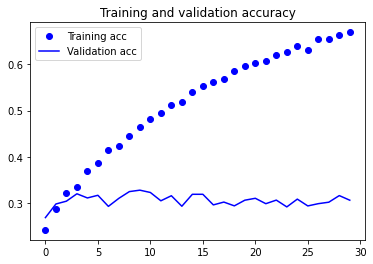

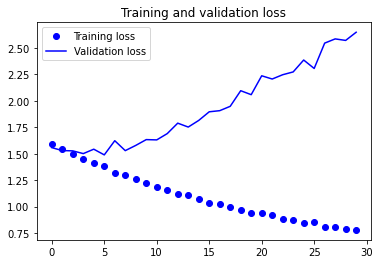

In [48]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
# Save the Model
model.save('text_model_1.h5')

### Model #2  (Student Name: XXXX)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31998, 70)
(8000, 70)
(31998,)
(8000,)


In [33]:
# Build the Model
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

max_features = vocab_size

model2 = Sequential()
model2.add(Embedding(max_features, 8, input_length=max_length))
model2.add(GRU(512, return_sequences=True))
model2.add(GRU(256))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32))
model2.add(Dense(5, activation='softmax'))

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 8)             120000    
                                                                 
 gru (GRU)                   (None, 70, 512)           801792    
                                                                 
 gru_1 (GRU)                 (None, 256)               591360    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [34]:
# Train the Model
history = model2.fit(X_train, y_train,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.8)


Epoch 1/50
13/13 [==============================] - 159s 12s/step - loss: 1.5989 - acc: 0.2455 - val_loss: 1.5872 - val_acc: 0.2425
Epoch 2/50
13/13 [==============================] - 160s 13s/step - loss: 1.5507 - acc: 0.2736 - val_loss: 1.5588 - val_acc: 0.2779
Epoch 3/50
13/13 [==============================] - 155s 13s/step - loss: 1.4996 - acc: 0.3179 - val_loss: 1.5323 - val_acc: 0.3138
Epoch 4/50
13/13 [==============================] - 153s 12s/step - loss: 1.4551 - acc: 0.3405 - val_loss: 1.5207 - val_acc: 0.3005
Epoch 5/50
13/13 [==============================] - 151s 12s/step - loss: 1.3962 - acc: 0.3763 - val_loss: 1.5345 - val_acc: 0.3274
Epoch 6/50
13/13 [==============================] - 135s 11s/step - loss: 1.3516 - acc: 0.4079 - val_loss: 1.5054 - val_acc: 0.3246
Epoch 7/50
13/13 [==============================] - 138s 11s/step - loss: 1.2988 - acc: 0.4358 - val_loss: 1.5775 - val_acc: 0.3342
Epoch 8/50
13/13 [==============================] - 151s 12s/step - loss: 1.

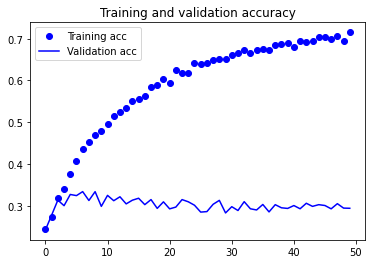

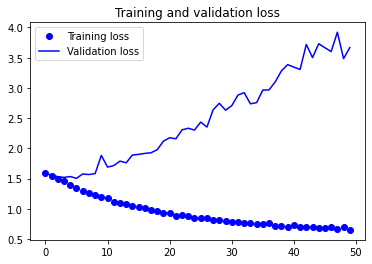

In [35]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
model2.save('text_model_2.h5')

### Model #3  (Student Name: XXXX)

In [32]:
# Build the Model
#y_train = to_categorical(y_train)
#y_test= to_categorical(y_test)

max_features = vocab_size
embedding_dim = 8
input_length = max_length

model3 = Sequential()
model3.add(Embedding(max_features, embedding_dim, input_length=max_length))
model3.add(GRU(256, return_sequences=True))
model3.add(GRU(128))
model3.add(Dense(128, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model3.add(Dense(128, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32))
model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 8)             120000    
                                                                 
 gru (GRU)                   (None, 70, 256)           204288    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [33]:
# Train the Model
history = model3.fit(X_train, y_train,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.8)

Epoch 1/30
13/13 [==============================] - 64s 4s/step - loss: 1.8057 - acc: 0.2322 - val_loss: 1.7603 - val_acc: 0.2499
Epoch 2/30
13/13 [==============================] - 50s 4s/step - loss: 1.7103 - acc: 0.2860 - val_loss: 1.6848 - val_acc: 0.2861
Epoch 3/30
13/13 [==============================] - 51s 4s/step - loss: 1.6434 - acc: 0.3019 - val_loss: 1.6405 - val_acc: 0.2879
Epoch 4/30
13/13 [==============================] - 51s 4s/step - loss: 1.5748 - acc: 0.3263 - val_loss: 1.6123 - val_acc: 0.3074
Epoch 5/30
13/13 [==============================] - 52s 4s/step - loss: 1.5237 - acc: 0.3511 - val_loss: 1.5823 - val_acc: 0.3121
Epoch 6/30
13/13 [==============================] - 51s 4s/step - loss: 1.4688 - acc: 0.3580 - val_loss: 1.5812 - val_acc: 0.3034
Epoch 7/30
13/13 [==============================] - 51s 4s/step - loss: 1.4327 - acc: 0.3676 - val_loss: 1.5826 - val_acc: 0.3070
Epoch 8/30
13/13 [==============================] - 51s 4s/step - loss: 1.4063 - acc: 0.38

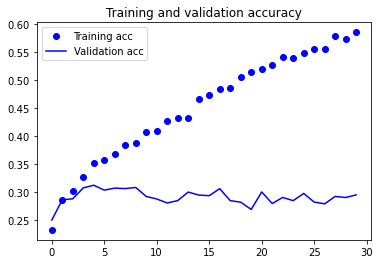

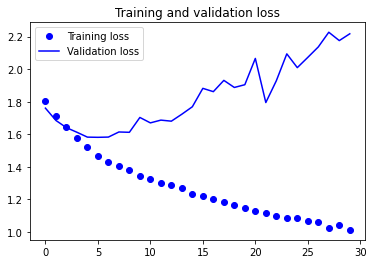

In [34]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
# Save the Model
model3.save('best_model_Vincent.h5')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

In [36]:
facebook_dataset = df[['content_final','score']]
facebook_dataset.to_csv("facebook_dataset.csv")

1. Standardizing the Facebook Dataset

In [41]:
facebook_dataset = pd.read_csv("facebook_dataset.csv")
def strings(text):
    text = str(text)
    return text

facebook_dataset['content_final'] = facebook_dataset['content_final'].apply(lambda x:strings(x))
facebook_dataset


,Unnamed: 0,content_final,score
0,0,is amazing,0
1,1,nice,0
2,2,facebook doch chkea crash lhot,0
3,3,bjw ව ව ද ඹ ව ව w w,0
4,4,is app authentication code generate,0
...,...,...,...
39993,39993,good,4
39994,39994,wusihclzh,4
39995,39995,nice,4
39996,39996,excellent experience,4


In [42]:
instagram_dataset = pd.read_csv("Group/insta_dataset.csv")
def strings(text):
    text = str(text)
    return text

instagram_dataset['content_final'] = instagram_dataset['content_final'].apply(lambda x:strings(x))
instagram_dataset

,content_final,score
0,app not opening update many uninstalls install...,0
1,super ok,0
2,cant install instagram app have tried for past...,0
3,is time wasting app me,0
4,app not working sir plz fix cant open instagra...,0
...,...,...
38207,happy life,4
38208,nice app,4
38209,love insta revolvinghearts,4
38210,is vrey op aap please downlod try app,4


In [43]:
templerun_dataset = pd.read_csv("Group/templerun_dataset.csv")
def strings(text):
    text = str(text)
    return text

templerun_dataset['content_final'] = templerun_dataset['content_final'].apply(lambda x:strings(x))
templerun_dataset

,content_final,score
0,thanks,0
1,good game,0
2,is super game,0
3,fing game,0
4,good morning baby girl,0
...,...,...
37960,ganesh o,4
37961,because is wonderful,4
37962,favorite game a kid,4
37963,best game ever milkyway,4


In [44]:
disney_dataset = pd.read_csv("Group/disney_dataset.csv")
def strings(text):
    text = str(text)
    return text

disney_dataset['content_final'] = disney_dataset['content_final'].apply(lambda x:strings(x))
disney_dataset

,content_final,score
0,problem until 4 month ago no matter solution t...,0
1,cant launch application the update cannot use ...,0
2,app never work properly lag like crazy dont re...,0
3,keep crashing freezing downloads,0
4,do want like but app refuse load since 3rd epi...,0
...,...,...
38850,favorite my childrens favorite,4
38851,different movie ever go i can which movie fami...,4
38852,perfect channel watch great movie specifically...,4
38853,great app adult child,4


In [45]:
snapchat_dataset = pd.read_csv("Group/snapchat_dataset.csv")
def strings(text):
    text = str(text)
    return text

snapchat_dataset['content_final'] = snapchat_dataset['content_final'].apply(lambda x:strings(x))
snapchat_dataset

,content_final,score
0,best apps,0
1,lag,0
2,adnan,0
3,have install snapchat a day snapchat se 1 mess...,0
4,pic qwality low,0
...,...,...
37922,muzmlekana,4
37923,ok,4
37924,is nice app,4
37925,superb,4


In [46]:
instagram_dataset = pd.read_csv("Group/insta_dataset.csv")
def strings(text):
    text = str(text)
    return text

instagram_dataset['content_final'] = instagram_dataset['content_final'].apply(lambda x:strings(x))
instagram_dataset
X_instagram = instagram_dataset['content_final']
y_instagram = instagram_dataset['score']

instagram_training_seqs = tokenizer.texts_to_sequences(instagram_dataset['content_final'])
instagram_train_padded = pad_sequences(instagram_training_seqs,
                                      maxlen = max_length,
                                      truncating = trunc_type,
                                      padding = "pre")
X_train_instagram,X_test_instagram,y_train_instagram,y_test_instagram = train_test_split(instagram_train_padded,
                                                                                          y_instagram,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

model = load_model("Group/best_model_jr.h5")
model.evaluate(X_test_instagram,y_test_instagram,batch_size = 32)

239/239 [==============================] - 8s 26ms/step - loss: 2.1798 - acc: 0.2243


[2.1798408031463623, 0.2242574840784073]

In [47]:
facebook_dataset = pd.read_csv("facebook_dataset.csv")
def strings(text):
    text = str(text)
    return text

facebook_dataset['content_final'] = facebook_dataset['content_final'].apply(lambda x:strings(x))
facebook_dataset
X_facebook = facebook_dataset['content_final']
y_facebook= facebook_dataset['score']

facebook_training_seqs = tokenizer.texts_to_sequences(facebook_dataset['content_final'])
facebook_train_padded = pad_sequences(facebook_training_seqs,
                                      maxlen = max_length,
                                      truncating = trunc_type,
                                      padding = "pre")
X_train_facebook,X_test_facebook,y_train_facebook,y_test_facebook = train_test_split(facebook_train_padded,
                                                                                          y_facebook,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

model = load_model("best_model_vincent.h5")
model.evaluate(X_test_facebook,y_test_facebook,batch_size = 32)

250/250 [==============================] - 21s 76ms/step - loss: 2.2245 - acc: 0.2960


[2.22448468208313, 0.29600000381469727]

In [48]:
templerun_dataset = pd.read_csv("Group/templerun_dataset.csv")
def strings(text):
    text = str(text)
    return text

templerun_dataset['content_final'] = templerun_dataset['content_final'].apply(lambda x:strings(x))
templerun_dataset
X_templerun = templerun_dataset['content_final']
y_templerun= templerun_dataset['score']

templerun_training_seqs = tokenizer.texts_to_sequences(templerun_dataset['content_final'])
templerun_train_padded = pad_sequences(templerun_training_seqs,
                                      maxlen = max_length,
                                      truncating = trunc_type,
                                      padding = "pre")
X_train_templerun,X_test_templerun,y_train_templerun,y_test_templerun = train_test_split(templerun_train_padded,
                                                                                          y_templerun,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

model = load_model("Group/best_model_cj.h5")
model.evaluate(X_test_templerun,y_test_templerun,batch_size = 32)

238/238 [==============================] - 12s 37ms/step - loss: 2.5182 - acc: 0.1912


[2.5182113647460938, 0.19122876226902008]

In [49]:
disney_dataset = pd.read_csv("Group/disney_dataset.csv")
def strings(text):
    text = str(text)
    return text

disney_dataset['content_final'] = disney_dataset['content_final'].apply(lambda x:strings(x))
disney_dataset
X_disney = disney_dataset['content_final']
y_disney= disney_dataset['score']

disney_training_seqs = tokenizer.texts_to_sequences(disney_dataset['content_final'])
disney_train_padded = pad_sequences(disney_training_seqs,
                                      maxlen = max_length,
                                      truncating = trunc_type,
                                      padding = "pre")
X_train_disney,X_test_disney,y_train_disney,y_test_disney = train_test_split(disney_train_padded,
                                                                                          y_disney,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

model = load_model("Group/best_model_kc.h5")
model.evaluate(X_test_disney,y_test_disney,batch_size = 32)

243/243 [==============================] - 7s 20ms/step - loss: 2.6768 - acc: 0.2442


[2.6768457889556885, 0.24424141645431519]

In [50]:
snapchat_dataset = pd.read_csv("Group/snapchat_dataset.csv")
def strings(text):
    text = str(text)
    return text

snapchat_dataset['content_final'] = snapchat_dataset['content_final'].apply(lambda x:strings(x))
snapchat_dataset
X_snapchat = snapchat_dataset['content_final']
y_snapchat= snapchat_dataset['score']

snapchat_training_seqs = tokenizer.texts_to_sequences(snapchat_dataset['content_final'])
snapchat_train_padded = pad_sequences(snapchat_training_seqs,
                                      maxlen = max_length,
                                      truncating = trunc_type,
                                      padding ="pre")
X_train_snapchat,X_test_snapchat,y_train_snapchat,y_test_snapchat = train_test_split(snapchat_train_padded,
                                                                                          y_snapchat,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

model = load_model("Group/best_model_dominic.h5")
model.evaluate(X_test_snapchat,y_test_snapchat,batch_size = 32)

238/238 [==============================] - 10s 29ms/step - loss: 2.6377 - acc: 0.2162


[2.6376521587371826, 0.2161877155303955]

3.2 Evaluating the test accuracies for the Facebook model accross all 5 datasets

In [51]:
print("[Facebook Model] Test accuracy of Instagram Dataset")
model.evaluate(X_test_instagram,y_test_instagram)

[Facebook Model] Test accuracy of Instagram Dataset
239/239 [==============================] - 7s 29ms/step - loss: 2.6602 - acc: 0.2095


[2.6601898670196533, 0.20947271585464478]

In [52]:
print("[Facebook Model] Test accuracy of Facebook Dataset")
model.evaluate(X_test,y_test)

[Facebook Model] Test accuracy of Facebook Dataset
250/250 [==============================] - 10s 29ms/step - loss: 2.3666 - acc: 0.2201


[2.3666152954101562, 0.2201250046491623]

In [53]:
print("[Facebook Model] Test accuracy of Temple Run Dataset")
model.evaluate(X_test_templerun,y_test_templerun)

[Facebook Model] Test accuracy of Temple Run Dataset
238/238 [==============================] - 7s 30ms/step - loss: 2.6021 - acc: 0.2095


[2.6021273136138916, 0.20953509211540222]

In [54]:
print("[Facebook Model] Test accuracy of Disney+ Dataset")
model.evaluate(X_test_disney,y_test_disney)

[Facebook Model] Test accuracy of Disney+ Dataset
243/243 [==============================] - 7s 30ms/step - loss: 2.9950 - acc: 0.2087


[2.995002031326294, 0.2087247520685196]

In [55]:
print("[Facebook Model] Test accuracy of Snapchat Dataset")
model.evaluate(X_test_snapchat,y_test_snapchat)

[Facebook Model] Test accuracy of Snapchat Dataset
238/238 [==============================] - 7s 30ms/step - loss: 2.6377 - acc: 0.2162


[2.6376521587371826, 0.2161877155303955]

In [56]:
# Save the Best Model
model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction (Group)

In [ ]:
best_model = load_model('text_model_best.h5')

In [ ]:
# takes the user input
text_input = np.array([input()])

In [ ]:
# convert the user input into numeric tensor


In [ ]:
# show the model output using predict function

